In [ ]:
# libraries

import os
import re
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from pickle import dump, load

from pathlib import Path
from PIL import Image

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from tensorflow.keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_v3 import InceptionV3,preprocess_input

In [ ]:
# download glove vectores

!wget --no-check-certificate \
http://nlp.stanford.edu/data/glove.6B.zip \
-O /tmp/glove.6B.zip

with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

# Download Dataset

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!unzip Flickr8k_Dataset.zip -d all_images
!unzip Flickr8k_text.zip -d all_captions

# Let's see what is the different between token and lemma token file in the text file

In [ ]:
texts_file = open('/content/all_captions/Flickr8k.token.txt', 'r')
texts_file = texts_file.read()
texts_file = texts_file.split('\n')
texts_file = texts_file[:-1]
texts_file[:10]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .']

In [ ]:
lem_file = open('/content/all_captions/Flickr8k.lemma.token.txt', 'r')
lem_file = lem_file.read()
lem_file = [sen for sen in lem_file.split('\n') if sen.startswith(texts_file[1][:20])]
lem_file

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress be climb up a set of stair in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl go into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climb into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climb the stair to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress go into a wooden cabin .']

***I prefer to work with the token file, not the lemma, because I want generate some meaningful sentences for images***

In [ ]:
texts_dict = {}

for des in texts_file:
  if des.split('\t')[0][:-2] not in texts_dict:
    texts_dict[des.split('\t')[0][:-2]] = [des.split('\t')[1]]
  else:
    texts_dict[des.split('\t')[0][:-2]].append(des.split('\t')[1])

texts_df = pd.DataFrame({'ImageName':list(texts_dict.keys()),
                         'ImageDescription':list(texts_dict.values())})

In [ ]:
image_dir = Path('/content/all_images/Flicker8k_Dataset')
image_paths = list(image_dir.glob(r'**/*.jpg'))
image_str_paths = pd.Series(image_paths, name='ImagePath').astype(str)
image_names = pd.Series([i.split("/")[-1] for i in image_str_paths], name='ImageName')
df = pd.concat([image_str_paths,image_names], axis=1)
df = df.merge(texts_df, on='ImageName')
df.head(5)

,ImagePath,ImageName,ImageDescription
0,/content/all_images/Flicker8k_Dataset/27096483...,2709648336_15455e60b2.jpg,[A brown dog in midair with a Frisbee in his m...
1,/content/all_images/Flicker8k_Dataset/28912401...,2891240104_6755281868.jpg,[A group of workers are posing for a picture ....
2,/content/all_images/Flicker8k_Dataset/34582156...,3458215674_2aa5e64643.jpg,[A couple of people are riding ATV 's on a dir...
3,/content/all_images/Flicker8k_Dataset/25914864...,2591486448_48d5438343.jpg,[A brown dog is wanting food from a plate held...
4,/content/all_images/Flicker8k_Dataset/32676443...,3267644370_f2728d6c7a.jpg,"[a person snowboarding on a refrigerator, A re..."


# Now let's look at Images

In [ ]:
def show_image(df):
  plt.figure(figsize=(20,10), dpi=100)
  for i in range(3):
    image_name = df['ImagePath'][i]
    captions = df.loc[df['ImagePath']==image_name, 'ImageDescription']

    ax = plt.subplot(1, 3, i+1)
    img = Image.open(image_name)
    plt.imshow(img.resize((229,229)))
    ax.set_title([cap[0] for cap in captions][0])

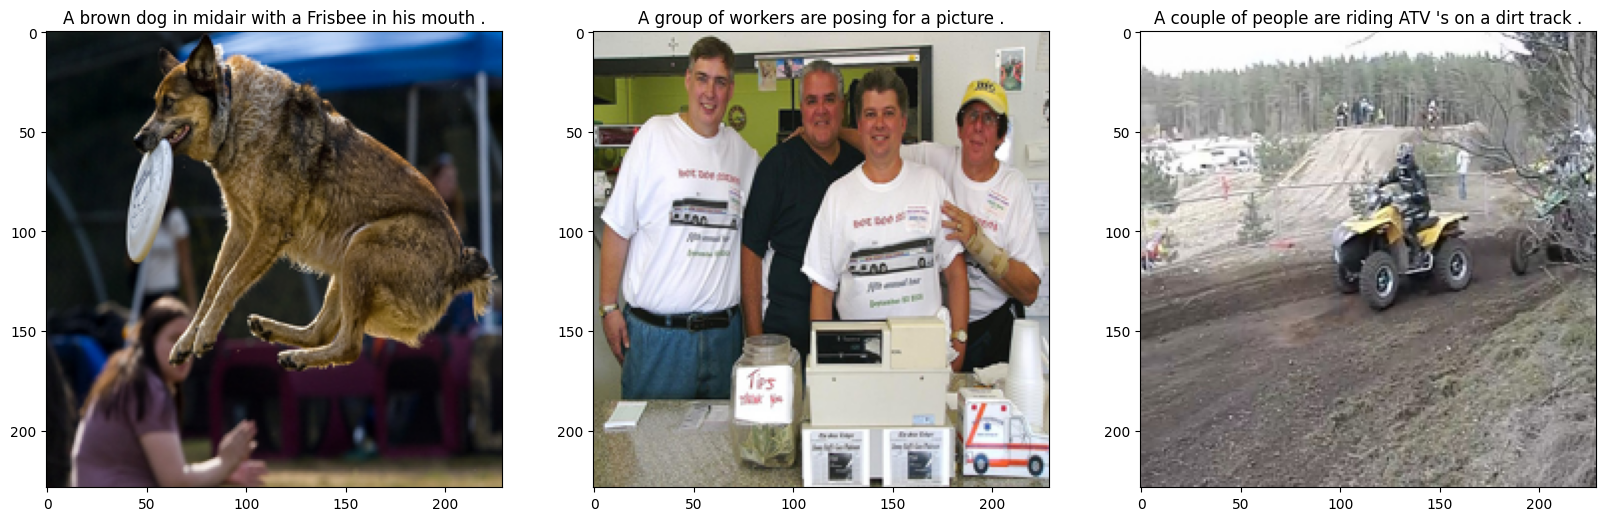

In [ ]:
show_image(df)

# Text processing

In [ ]:
df.head()

,ImagePath,ImageName,ImageDescription
0,/content/all_images/Flicker8k_Dataset/27096483...,2709648336_15455e60b2.jpg,[A brown dog in midair with a Frisbee in his m...
1,/content/all_images/Flicker8k_Dataset/28912401...,2891240104_6755281868.jpg,[A group of workers are posing for a picture ....
2,/content/all_images/Flicker8k_Dataset/34582156...,3458215674_2aa5e64643.jpg,[A couple of people are riding ATV 's on a dir...
3,/content/all_images/Flicker8k_Dataset/25914864...,2591486448_48d5438343.jpg,[A brown dog is wanting food from a plate held...
4,/content/all_images/Flicker8k_Dataset/32676443...,3267644370_f2728d6c7a.jpg,"[a person snowboarding on a refrigerator, A re..."


In [ ]:
def clean_text(descriptions):
  for i in range(len(descriptions)):
    sentence = descriptions[i]
    sentence = re.sub('[^a-z A-Z]', '', sentence)
    sentence = str(sentence).lower()
    sentence = sentence.split()
    sentence = [token for token in sentence if len(token)>1]
    descriptions[i] = '<start> ' + " ".join(sentence) + ' <end>'
  return descriptions

In [ ]:
df['ImageDescription'] = df['ImageDescription'].apply(clean_text)

In [ ]:
vocab = set()
for i in range(len(df)):
  [vocab.update(d.split()) for d in df['ImageDescription'][i]]
initial_vocab_size = len(vocab)
initial_vocab_size

8767

In [ ]:
def dict_to_list(descriptions):
  all_desc = []
  for i in range(len(df)):
      [all_desc.append(d) for d in descriptions[i]]
  return all_desc

In [ ]:
text_lst = dict_to_list(df['ImageDescription'])
max_len = max(len(sen.split()) for sen in text_lst)
max_len

34

In [ ]:
df.head(2)

,ImagePath,ImageName,ImageDescription
0,/content/all_images/Flicker8k_Dataset/27096483...,2709648336_15455e60b2.jpg,[<start> brown dog in midair with frisbee in h...
1,/content/all_images/Flicker8k_Dataset/28912401...,2891240104_6755281868.jpg,[<start> group of workers are posing for pictu...


##Making weight matrix for Word Embedding with Word2vec and Glove

Word2Vec

In [ ]:
def word2vec_embed():
  # convert all the descriptions in the descriptions lists to a list of lists contains all the words in the descriptions --> what Word2Vec wants
  text = [i.split() for i in text_lst]
  embedding_model = Word2Vec(sentences=text,
                            vocab_size=100,
                            min_count=1,
                            window=5,
                            workers=4)

  # create embadding matrix based on wor2vec
  word2vec_embedding_matrix = embedding_model.wv.vectors
  vocab_size = word2vec_embedding_matrix.shape[0]
  tokenizer = Tokenizer(num_words=vocab_size)
  tokenizer.fit_on_texts(text_lst)
  return tokenizer, vocab_size, word2vec_embedding_matrix

Glove

In [ ]:
def glove_embed():
  # create glove dict
  embeddings_dict = {}
  with open('/tmp/glove/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype="float32")
        embeddings_dict[word] = vec

  # in glove, we need define the shape of the embedding matrix ourself, then we need to fit tokenizer on our corpus first and then continue
  tokenizer = Tokenizer(num_words=initial_vocab_size)
  tokenizer.fit_on_texts(text_lst)
  word2idx = tokenizer.word_index

  # create embadding matrix based on glove
  glove_embedding_matrix = np.zeros((len(word2idx) + 1, 100))
  for word, i in word2idx.items():
    if i < initial_vocab_size:
      embedding_vector = embeddings_dict.get(word)
      if embedding_vector is not None:
        glove_embedding_matrix[i] = embedding_vector

  vocab_size = glove_embedding_matrix.shape[0]
  return tokenizer, vocab_size, glove_embedding_matrix

# Image Proccessing

In [ ]:
features = []
feature_extractor = Xception(include_top=False, pooling='avg')
for image in tqdm(df['ImagePath']):
  img = Image.open(image)
  img = img.resize((229,229))
  img = np.expand_dims(img, axis=0)
  img = img/127.5
  img-=1

  img_feature = feature_extractor.predict(img, verbose=0)
  features.append(img_feature)

83683744/83683744 [==============================] - 0s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
df['ImageFeature'] = features
dump(features, open("features.p", "wb"))

In [ ]:
# features = load(open("features.p", "rb"))
# df['ImageFeature'] = features

## Generate propare DataSet for Image Captioning

In [ ]:
def data_generator(df, max_len, embedding, num_photos_per_batch):
  tokenizer = embedding[0]
  vocab_size = embedding[1]
  X1, X2, y = list(), list(), list()
  n=0
  while 1:
      for i in range(len(df)):
          n+=1
          features = df['ImageFeature'][i][0]
          descriptions = df['ImageDescription'][i]

          for desc in descriptions:
              seq = tokenizer.texts_to_sequences([desc])
              seq = seq[0]
              for i in range(1,len(seq)):
                  in_seq , op_seq = seq[:i],seq[i]
                  in_seq = pad_sequences([in_seq], maxlen=max_len, padding="post")[0]
                  op_seq = to_categorical([op_seq],num_classes=vocab_size)[0]
                  X1.append(features)
                  X2.append(in_seq)
                  y.append(op_seq)
          if n==num_photos_per_batch:
              yield [[np.array(X1), np.array(X2)], np.array(y)]
              X1, X2, y = list(), list(), list()
              n=0

## Build the Model

In [ ]:
def define_model(embedding, max_len):
    embedding_matrix = embedding[2]
    vocab_size = embedding[1]
    inputs1 = tf.keras.layers.Input(shape=(2048,))
    fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
    fe2 = tf.keras.layers.Dense(300, activation='relu')(fe1)


    inputs2 = tf.keras.layers.Input(shape=(max_len,))
    se1 = tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0],
                                    output_dim=embedding_matrix.shape[1],
                                    mask_zero=True,
                                    weights=[embedding_matrix],
                                    trainable=False)(inputs2)
    se2 = tf.keras.layers.Dropout(0.5)(se1)
    se3 = tf.keras.layers.LSTM(300)(se2)

    decoder1 = tf.keras.layers.Add()([fe2, se3])
    decoder2 = tf.keras.layers.Dense(300, activation='relu')(decoder1)
    outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)

    model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    return model

## Prediction Phase

In [ ]:
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None
def generate_desc(model, tokenizer, features, max_len):
  in_text = 'start'
  for i in range(max_len):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_len)
    pred = model.predict([features,sequence], verbose=0)
    pred = np.argmax(pred)
    word = word_for_id(pred, tokenizer)
    if word is None:
        break
    in_text += ' ' + word
    if word == 'end':
        break
  return in_text

In [ ]:
test_img = '/content/GettyImages-470691529-5949be9d5f9b58d58a0354c9.jpg'
test_features = []
img = Image.open(test_img)
img = img.resize((229,229))
img = np.expand_dims(img, axis=0)
img = img/127.5
img-=1
img_feature = feature_extractor.predict(img, verbose=0)
test_features.append(img_feature)

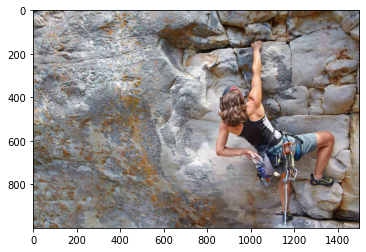

In [ ]:
plt.imshow(Image.open(test_img))

In [ ]:
batch_size = number_pics_per_bath = 10
steps = len(df)//number_pics_per_bath

## Word2Vec Performance

In [ ]:
# Data Generating
word2vec_embedding = word2vec_embed()
word2vec_generator = data_generator(df, max_len, word2vec_embedding, number_pics_per_bath)
word2vec_model = define_model(word2vec_embedding, max_len)

# Training Phase
word2vec_model.fit_generator(word2vec_generator, epochs=50, steps_per_epoch=steps, verbose=1)

# Prediction Phase
word2vec_description = generate_desc(word2vec_model, word2vec_embedding[0], test_features, max_len)
print(word2vec_description)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 34, 100)      876700      ['input_7[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 2048)         0           ['input_6[0][0]']                
                                                                                            

<ipython-input-39-ff871c13952c>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  word2vec_model.fit_generator(word2vec_generator, epochs=50, steps_per_epoch=steps, verbose=1)


809/809 [==============================] - 43s 48ms/step - loss: 4.8069
Epoch 2/50
809/809 [==============================] - 38s 47ms/step - loss: 3.9151
Epoch 3/50
809/809 [==============================] - 38s 47ms/step - loss: 3.6020
Epoch 4/50
809/809 [==============================] - 38s 47ms/step - loss: 3.3889
Epoch 5/50
809/809 [==============================] - 38s 47ms/step - loss: 3.2198
Epoch 6/50
809/809 [==============================] - 38s 47ms/step - loss: 3.0812
Epoch 7/50
809/809 [==============================] - 38s 47ms/step - loss: 2.9743
Epoch 8/50
809/809 [==============================] - 38s 47ms/step - loss: 2.8882
Epoch 9/50
809/809 [==============================] - 38s 47ms/step - loss: 2.8155
Epoch 10/50
809/809 [==============================] - 38s 47ms/step - loss: 2.7572
Epoch 11/50
809/809 [==============================] - 38s 47ms/step - loss: 2.7093
Epoch 12/50
809/809 [==============================] - 38s 47ms/step - loss: 2.6660
Epoch 13/50


In [ ]:
test_img = '/content/senior-dog-cat-cuddling-web.jpg'
test_features = []
img = Image.open(test_img)
img = img.resize((229,229))
img = np.expand_dims(img, axis=0)
img = img/127.5
img-=1
img_feature = feature_extractor.predict(img, verbose=0)
test_features.append(img_feature)

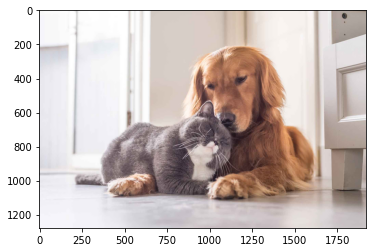

In [ ]:
plt.imshow(Image.open(test_img))

In [ ]:
word2vec_description = generate_desc(word2vec_model, word2vec_embedding[0], test_features, max_len)
print(word2vec_description)

start brown dog is shaking itself dry end


## Glove Performance

In [ ]:
# Data Generating
glove_embedding = glove_embed()
glove_generator = data_generator(df, max_len, glove_embedding, number_pics_per_bath)
glove_model = define_model(glove_embedding, max_len)

# Training Phase
glove_model.fit_generator(glove_generator, epochs=50, steps_per_epoch=steps, verbose=1)

# Prediction Phase
glove_description = generate_desc(glove_model, glove_embedding[0], test_features, max_len)
print(glove_description)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 34, 100)      876600      ['input_9[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 2048)         0           ['input_8[0][0]']                
                                                                                            

<ipython-input-43-023f727fd618>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  glove_model.fit_generator(glove_generator, epochs=50, steps_per_epoch=steps, verbose=1)


809/809 [==============================] - 43s 48ms/step - loss: 4.7057
Epoch 2/50
809/809 [==============================] - 37s 46ms/step - loss: 3.8266
Epoch 3/50
809/809 [==============================] - 37s 46ms/step - loss: 3.5087
Epoch 4/50
809/809 [==============================] - 38s 47ms/step - loss: 3.3003
Epoch 5/50
809/809 [==============================] - 37s 45ms/step - loss: 3.1372
Epoch 6/50
809/809 [==============================] - 37s 45ms/step - loss: 3.0022
Epoch 7/50
809/809 [==============================] - 37s 46ms/step - loss: 2.8962
Epoch 8/50
809/809 [==============================] - 37s 45ms/step - loss: 2.8102
Epoch 9/50
809/809 [==============================] - 38s 47ms/step - loss: 2.7414
Epoch 10/50
809/809 [==============================] - 37s 45ms/step - loss: 2.6882
Epoch 11/50
809/809 [==============================] - 37s 46ms/step - loss: 2.6404
Epoch 12/50
809/809 [==============================] - 36s 45ms/step - loss: 2.5993
Epoch 13/50


In [ ]:
test_img = '/content/GettyImages-470691529-5949be9d5f9b58d58a0354c9.jpg'
test_features = []
img = Image.open(test_img)
img = img.resize((229,229))
img = np.expand_dims(img, axis=0)
img = img/127.5
img-=1
img_feature = feature_extractor.predict(img, verbose=0)
test_features.append(img_feature)

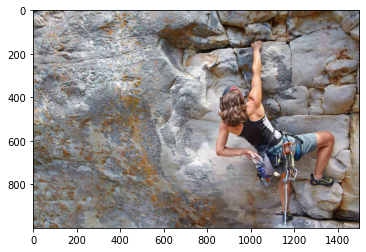

In [ ]:
plt.imshow(Image.open(test_img))

In [ ]:
glove_description = generate_desc(glove_model, glove_embedding[0], test_features, max_len)
print(glove_description)

start man in red shirt climbs rock wall end
